# **Chap4：循环神经网络RNN**

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import jieba
from tqdm import tqdm
import numpy as np
from source.code import ch4
from source.code import utils

In [3]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=0)

## **4.1 序列模型**

### **4.1.1 因果与马尔可夫链**

**序列数据**是人们生产生活中另一类常见的**非结构化数据**，它是指数据中的每个元素**需要按照一定的逻辑关系，或者因果关系排列**，**打乱这个排序将会使数据失去原有的意义**，例如：
* **时间序列数据**：某个国家的GDP随时间的变化，某支股票的股价数据
* **用户行为序列**：一个用户在电商平台的购买行为序列，或者是在短视频平台的点赞、收藏、关注行为序列
* **媒体信息序列**：文本、语音、音乐和视频，如果它们的序列被我们重排，那么就会失去原有的意义（比如“狗咬人”和“人咬狗”所传达的含义完全不同）

统计上，给定序列并作出预测包含两种问题：
* 给定序列 $T_1,T_2,\cdots,T_{k-1},T_{k+1},T_{k+2},\cdots$，然后补全 $T_k$，这称为**内插问题**或者**插值问题**（**interpolation**）
* 给定序列 $T_1,T_2,\cdots,T_{k-1},T_{k}$，然后预测 $T_{k+1},T_{k+2},\cdots$，这称为**外插问题**（**extrapolation**）

通常来说，**内插问题要比外插问题容易解决**，因为未知的样本在序列内发生突变的可能性比较小，在各种连续性或函数模型的假设下，我们可以用各种插值方法补全中间点，但**对外插点的预测比较困难**，因为没人能够判断下一个样本是否会遵循原来的变化趋势，或是突变到另一种变化模式，如果外插估计是容易的，那么人人都能通过炒股挣大钱

<img src="./source/Chap4/股价.png" width=600>

接下来我们讨论的问题都是**外插预测**，即在序列 $t\in\mathbb{Z}^+$ 处，**给定过去一段时间**（这里的时间是宽泛的概念，包含所有逻辑上的过去）的序列，对 $t$ 处的样本 $x_t$ 建模：
$$
x_t \sim P(x_t | x_{t-1},x_{t-2},\cdots)
$$ 

**(1) 自回归模型**

解决上述预测问题的，在实际操作时，有两种策略：
* **策略一**：在现实情况下相当长的所有历史序列 $x_{t-1},\cdots,x_1$ 可能是不必要的，我们只需要**截取历史某个长度为** $\tau$ **的子序列**，即使用观测序列 $x_{t-1},\cdots,x_{t-\tau}$，这样操作的**最大优势是建模的序列特征长度总是不变的**，永远为 $\tau$（至少在 $t > \tau$ 时可以满足），然后我们用
  $$
  x_t\sim P(x_t | x_{t-1},\cdots,x_{t-\tau})
  $$
  对 $x_t$ 建模，我们可以从样本中生成数据集，然后训练一个神经网络，这种主流方法称为**自回归模型**（**auto regressive model**）

* **策略二**：如下图所示，**通过建模保留一些对过去观测的总结** $h_t$，并且**同时更新预测** $\hat{x}_t$ **和总结** $h_t$，模型可以写作：
  $$
  h_t = g(h_{t-1},x_{t-1}),\quad \hat{x}_t = P(x_t | h_t)
  $$
  由于 $h_t$ 是**假设变量**，并未被真实观测到，这种方法也被称为**隐变量自回归模型**（**latent auto regressive model**）

<img src="./source/Chap4/LAR.svg" width=400>

无论是哪种策略，在训练数据的生成上，一般都是**用历史观测来预测下一个未来观测**，这种模型基于的假设是：**虽然特定值** $x_t$ **是随机变量会发生改变**，**但是序列本身** $x_t,x_{t-1},x_{t-2},\cdots$ **的动力学特点不会改变**，因此，整个长度为 $T$ 的序列的估计值都用下式建模：
$$
P(x_1,x_2,\cdots,x_T) = \prod_{t=1}^{T}P(x_t|x_{t-1},\cdots,x_1)
$$

这里的概率分布可以是针对连续分布（**即回归问题，例如股价预测**），也可以是离散分布（**即分类问题，例如单词预测**）

**(2) 马尔可夫模型**

在自回归模型的近似法中，我们用截断序列 $x_{t-1},\cdots,x_{t-\tau}$ 来估计 $x_t$，而不是 $x_{t-1},\cdots,x_1$，**如果这种近似是精确的**，我们就说序列满足**马尔可夫条件**，特别当 $\tau = 1$，得到的是**一阶马尔可夫模型**，概率模型为：
$$
P(x_1,\cdots,x_T) = \prod_{t=1}^{T} P(x_t|x_{t-1}),\quad P(x_1|x_0) = P(x_1)
$$

如果 $x_t$ 是离散序列，则模型将变得非常简单，我们可以用**动态规划**高效计算 $P(x_{t+1}|x_{t-1})$

$$
\begin{array}{rcl}
P(x_{t+1}|x_{t-1}) & = & \displaystyle{ \frac{\sum_{x_t} P(x_{t+1},x_t,x_{t-1})}{P(x_{t-1})} } \\
& = & \displaystyle{ \frac{\sum_{x_t} P(x_{t+1} | x_t,x_{t-1})P(x_t,x_{t-1}) }{P(x_{t-1})} } \\
& = & \displaystyle{ \sum_{x_t} P(x_{t+1} | x_t)P(x_t | x_{t-1}) } \\
\end{array}
$$

回顾随机过程中的马尔可夫模型，上式其实就是**马尔可夫模型中的两步转移概率**

**(3) 因果关系**

从数学上，我们可以将 $P(x_1,\cdots,x_T)$ 倒序展开，利用条件概率公式：
$$
P(x_1,\cdots,x_T) = \prod_{t=T}^1 P(x_t | x_{t+1},\cdots,x_T)
$$

然而，在许多情况下，**数据存在一个自然的方向，即在时间上是前进的**，即**未来的事件不能影响过去**：
* 因此，如果我们改变 $x_t$，则未来 $x_{t+1}$ 的分布很有可能被影响
* 但反过来，改变 $x_t$，基于过去事件得到的分布不会改变

对于大部分序列建模问题，这个**自然向前推进的方向恰好也是我们通常感兴趣的方向**

下面，我们以一个**带有噪声的正弦时间序列**为例，说明序列建模问题的基本流程

**(1) 数据生成**

我们使用正弦函数和一些可加性噪声来生成序列数据，时间步为 $1,2,\cdots,1000$

In [2]:
def generate_sin_signal(T : int=1000, show : bool=False) -> tf.Tensor:
    """
    Parameters
    ----------
    T : int, optional
        时间长度
    """
    time = tf.range(1, T + 1, dtype=tf.float32) # 时间步 1, 2, ..., T
    # 带噪声的正弦信号
    x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
    if show:
        fig = plt.figure(figsize=(6, 3))
        plt.plot(time, x)
        plt.xlabel('time')
        plt.ylabel('x')
    return time, x

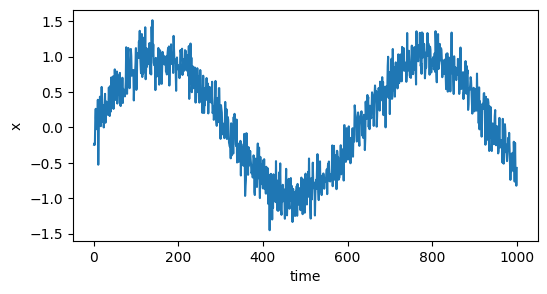

In [6]:
time, x = ch4.generate_sin_signal(show=True)

接下来，我们将这个序列转换为模型的**特征－标签对**（即**feature和label**），选择某个截断长度 $\tau$，我们**将标签和特征编排为数据对** $y_t = x_t$ 和 $\boldsymbol{x}_t = [x_{t-\tau},\cdots,x_{t-1}]$
* 长度不足 $\tau$ 的部分**直接丢弃**，这样得到的训练数据会比生成的数据少了 $\tau$ 个
* 当然，你也可以**保留它们**，长度不足 $\tau$ 的序列**用零填充**

In [4]:
def generate_training_samples(x : tf.Tensor, tau : int=5):
    """
    Parameters
    ----------
    x : tf.Tensor
        序列样本
    tau : int, default=5
        截断长度
    """
    T = len(x)
    # 初始化特征，形状 (T - tau, tau)
    features = tf.Variable(tf.zeros((T - tau, tau)))
    # 为特征赋值
    for i in range(tau):
        features[:, i].assign(x[i: T - tau + i])
    # 标签赋值，形状 (T - tau, 1)
    labels = tf.reshape(x[tau:], (-1, 1))

    return features, labels

选择截断长度为5，生成特征和标签

In [7]:
features, labels = ch4.generate_training_samples(x, tau=5)
print(features.shape, labels.shape)

(995, 5) (995, 1)


**(2) 创建模型进行训练**

我们搭建一个最简单的，拥有两层的全连接神经网络，使用ReLU激活函数和平方损失

In [6]:
def create_sin_signal_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)])
    return model

In [7]:
def train_sin_signal_model(model, x_train, y_train, batch_szie : int=32, lr=0.01, Epochs=5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_func = tf.keras.losses.MeanSquaredError() # 平方损失

    animator = utils.Animator(xlabel='epoch', ylabel='mse', xlim=[1, Epochs], legend=['train'])

    # 创建迭代器
    train_iter = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(batch_szie)
    for epoch in range(Epochs):
        for x_batch,y_batch in train_iter:
            with tf.GradientTape() as tape:
                y_hat = model(x_batch,training=True)
                loss = loss_func(y_hat, y_batch)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))
        
        y_hat = model(x_train)
        loss = loss_func(y_hat, y_train).numpy()
        animator.add(epoch + 1, (loss, ))
    
    return model

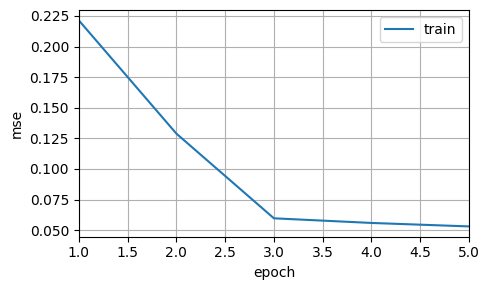

In [10]:
model = ch4.create_sin_signal_model()
# 使用前 500 个样本训练
n_train = 500
model = ch4.train_sin_signal_model(model, features[:n_train], labels[:n_train], Epochs=5)

**(3) 预测和评估**

由于训练损失很小，因此我们期望模型能有很好的工作效果，首先是检查**模型预测下一个时间步的能力**

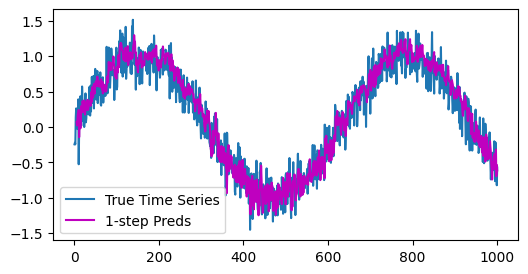

In [11]:
tau = 5 # 截断长度
onestep_preds = model(features)
fig = plt.figure(figsize=(6, 3))
plt.plot(time, x, label='True Time Series')
plt.plot(time[tau:], onestep_preds, label='1-step Preds',c="m")
plt.legend()

如我们所见，**单步预测效果不错**，模型在测试数据上 $t > 500$ 上的预测也依然是可信的

但在现实应用中，我们可能更希望模型做到**多步预测**，即得到预测 $\hat{x}_{t+1}$ 后，不等待真实的 $x_{t+1}$ 出现，想办法获得 $\hat{x}_{t+2},\hat{x}_{t+3},\cdots$，这通常是利用**滚动预测**（**rolling predict**）实现的

$$
\begin{array}{rcl}
\hat{x}_{t} & = & f(x_{t-1},\cdots,x_{t-\tau}) \\
\hat{x}_{t+1} & = & f(\hat{x}_t,\cdots,x_{t-\tau + 1}) \\
\hat{x}_{t+2} & = & f(\hat{x}_{t+1}, \hat{x}_t\cdots,x_{t-\tau + 2}) \\
\hat{x}_{t+3} & = & f(\hat{x}_{t+2},\hat{x}_{t+1},\hat{x}_t,\cdots,x_{t-\tau + 3}) \\
\end{array}
$$

向前滚动 $k$ 次，我们称 $\hat{x}_{t+k-1}$ 为 $k$ 步预测，滚动预测的核心是**用我们自己的预测（而不是原始数据）来进行多步预测**

In [14]:
max_steps, tau, T = 64, 5, 1000
# 初始化预测结果，形状 (T - tau - max_steps + 1, tau + max_steps)
predicts = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))

# 列 i 是来自 x 的观测
# 其时间步从 i 到 i+T-tau-max_steps+1
for i in range(tau):
    predicts[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# 开始向后滚动预测
for i in range(tau,tau + max_steps):
    # 列 i 是来自 i-tau+1 步的预测
    # 其时间步从 i 到 i+T-tau-max_steps+1
    predicts[:, i].assign(tf.reshape(model(predicts[:, i-tau : i]), (-1,)))

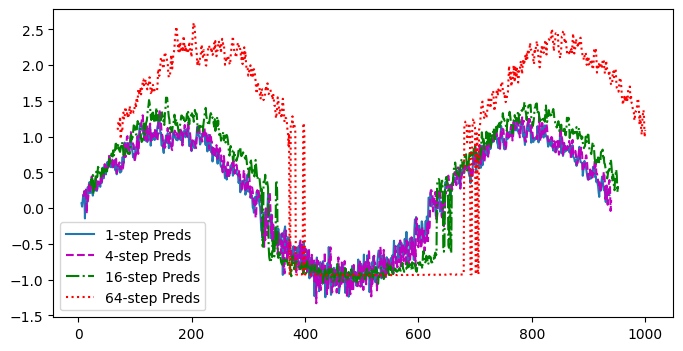

In [15]:
steps = (1, 4, 16, 64)
lines = ('-', 'm--', 'g-.', 'r:')
fig = plt.figure(figsize=(8,4))
for i,step in enumerate(steps):
    plt.plot(time[tau + step - 1:T - max_steps + step], 
             predicts[:, tau + step - 1].numpy(),
             lines[i], label="%d-step Preds"%(step))
plt.legend()

以上例子清楚地说明了**当我们试图预测更远的未来时，预测的质量越来越差**，虽然“4步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的

### **4.1.2 文本预处理**

本章的后续部分，我们将讨论深度学习模型在**自然语言处理**（**NLP**）领域的应用，在处理NLP任务时，最基本的学会文本预处理，这包括以下几个步骤：
1. **获取文本数据**（下载数据集，爬虫爬取文本），将文本作为字符串加载到内存中
2. 将**字符串拆分为词元**（如单词和字符）
3. 建立一个**词表**（**Vocab**），将拆分的词元映射到数字索引
4. 将**文本序列转换为数字索引序列**

**(1) 读取数据集**

我们这里**跳过文本数据集的收集过程**，在现实中，这往往需要通过爬虫工程获得，我们使用**中文维基百科数据集** `wiki_zh_2019` 来演示**中文文本的预处理流程**，习题中包含英文文本的预处理练习

In [16]:
# 导入文件
f = open("./source/data/text/wiki_zh_2019/wiki_zh_2019.txt")
lines = f.readlines() # 读取所有的行
f.close() # 关闭文件

print("总行数：",len(lines)) # 打印行数
print("第一行长度：",len(lines[0])) # 打印第一行
print("第一行前 20 个字符：",lines[0][:20]) # 打印第一行前 20 个字符

总行数： 1043224
第一行长度： 6364
第一行前 20 个字符： 数学  数学是利用符号语言研究数量、结构


**(2) 词元化**

中文分词我们需要用到python的 `jieba` 库，它能**从已有的词库中将一个中文句子拆分为离散的单词**，通过`jieba.cut()`完成分词，我们会得到一个生成器，然后使用`list()`可以将它转换为一个列表

In [19]:
# 将第一句话分词
words = list(jieba.cut(lines[0])) 
print("第一句话的词数：",len(words)) # 打印分词后的词数
# 查看分词的前 10 个词
print(words[:10])

第一句话的词数： 3974
['数学', ' ', ' ', '数学', '是', '利用', '符号语言', '研究', '数量', '、']


我们将词元化定义为一个函数 `tokenize()`，相比简单的分词，我们还需要**处理一下语句中多余的空格符号**，词元化有两种方式：
* 第一种，**按照词语分词**，将语句拆分为一个个词语
* 第二种，**按照字符分词**，将语句中每个字符拆分成为词元，在这种情况下，英语就只会包含26个词元外加其他特殊字符

由于词语是字符的排列组合，因此**使用词语分词，一般词元的种类会大很多**

In [20]:
def tokenize(lines : list, token : str="word"):
    """
    lines : list
        存储文本信息的列表
    token : str, default="word"
        分词方式，"word" 表示按词分词，"char" 表示按字符分词
    """
    tokens = []
    # 依次取出每一行
    # tqdm 可以显示进度条
    for line in tqdm(lines):
        # 去除空格，去除换行符
        line = line.replace(' ', '').replace('\n', '')
        # 分词
        if token == "word":
            words = list(jieba.cut(line)) # 按词分词
        elif token == "char":
            words = list(line) # 按字符分词
        tokens.append(words) # 添加到 tokens 中
    return tokens

由于样本量巨大，我们仅对前 `10000` 行样本进行分词

In [21]:
tokens = ch4.tokenize(lines[0:10000])

100%|██████████| 10000/10000 [01:00<00:00, 166.13it/s]


**(3) 创建词表Vocab**

词元的类型是字符，而**模型需要的输入是数字，因此这种类型不方便模型使用**，我们需要创建一个字典，**将每个字符映射到一个唯一的整数索引**，通常这个字典也被叫做**词表**（**Vocab**），**词表的索引从数字 0 开始**，它不断读取数据集中的每一个词元，对它们唯一的词元进行统计，得到的**统计结果称为语料**
* 词表根据每个唯一词元的出现频率，为其分配一个数字索引
* 我们需要四个特殊的词元`<bos>`，`<eos>`，`<pad>`和`<unk>`
  * `<bos>` 表示**开始词元**，意味着一个句子的开始
  * `<eos>` 表示**结束词元**，意味着一个句子的结束
  * `<pad>` 表示**填充词元**，用来将较短的句子填充到模型所需的固定长度
  * `<unk>` 表示**未知词元**，模型在计算时，可能会遇到语料库中不包含的词元，这时候统一将它们视为未知词元处理，当语料库比较大时，一个句子中出现未知词元的可能性很小
* **很少出现的词元通常被移除，这可以降低复杂性**，可以理解为，它们会被模型统一当作`<unk>`处理

In [33]:
class Vocab:
    def __init__(self, tokens=None, min_freq : int=0) -> None:
        if tokens is None:
            tokens = []
        # 统计每个词元出现的频率
        # 结果以字典的形式保存，key 表示词元，value 表示词元频率
        counter = self.count_corpus(tokens)
        # 按出现频率排序，按照 value 降序
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 初始化从索引到词元的映射
        # unk 的索引为 0, bos 的索引为 1，eos 的索引为 2，pad 的索引为 3
        self.idx_to_token = ['<unk>', '<bos>', '<eos>', '<pad>']
        # 初始化从词元到索引的映射
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self.token_freqs:
            # 过滤掉低频词元
            if freq < min_freq:
                break
            # 将未出现过的词元，添加到词表中
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    # 统计词元的频率
    def count_corpus(self, tokens):
        from collections import Counter
        # 这里的 tokens 是 2D 列表
        # tokens 的每个元素是一个包含词元的列表
        # 将词元列表展平成一个列表
        if isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
    

        return Counter(tokens)
    
    # 词表的 len 方法
    def __len__(self):
        return len(self.idx_to_token)

    # 词表的下标访问 getitem 方法
    # 给定词元或词元列表，返回词元的索引
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # 没见过的词，返回 unk 的索引
            return self.token_to_idx.get(tokens, self.token_to_idx['<unk>'])
        return [self.__getitem__(token) for token in tokens]
    
    # 给定词元索引或索引列表，返回词元
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

接下来，创建词表，我们先不过滤任何词，然后绘制词出现的频率分布

In [34]:
ch_vocab = ch4.Vocab(tokens, min_freq=0) # 不过滤低频词元
print("词表大小：",len(ch_vocab))

词表大小： 379149


In [35]:
ch_vocab.__getitem__(['我', '爱', '数学'])

[222, 1529, 542]

整个**词表中包含了接近40万个词**，接下来绘制词频的分布

词频的 80% 分位数： 6.0


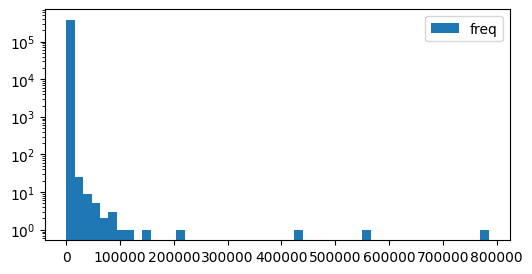

In [19]:
fig = plt.figure(figsize=(6,3))
freqs = [token[1] for token in ch_vocab.token_freqs]
plt.hist(freqs,bins=50,log=True,label="freq")
plt.legend()
# 查看词频的 80% 分位数
print("词频的 80% 分位数：",np.quantile(freqs,0.8))

上式意味着 **80% 的词元的出现频率小于 6**，我们可以重新创建词表，过滤掉出现次数小于 5 的词元

In [36]:
ch_vocab = ch4.Vocab(tokens, min_freq=5) # 过滤低频词元
print("词表大小：",len(ch_vocab))

词表大小： 92446


词表的大小快速减小了，现在只有接近10万个词了，我们可以测试一下

In [37]:
sentence = "我爱自然语言处理"
sentence = list(jieba.cut(sentence))
print("分割后词元：",sentence)
print("词表处理后索引：",ch_vocab[sentence])

分割后词元： ['我', '爱', '自然语言', '处理']
词表处理后索引： [222, 1529, 15859, 589]


当然，也可以反过来，提供索引，让词表转换为句子

In [38]:
indices = [222, 1529, 15859, 589]
ch_vocab.to_tokens(indices)

['我', '爱', '自然语言', '处理']

最后，我们将词元 `tokens` 利用词表 `ch_vocab` 转换为一个巨大的语料列表 `corpus`
* 这相当于**把所有数据集文本语句转换为对应的索引**
* `corpus` 可以是一个 2D 列表，每个元素代表一段语句的索引表达
* 如果数据集是一本书的文本，也可以把上面的 2D `corpus` 拼接为一整个列表，表示所有文本构成的语料

In [39]:
# 创建语料数据集
corpus = [ch_vocab[line] for line in tokens]
# 语料数据集包含的语句数量
corpus_len = len(corpus)
print("语料数据集长度：",corpus_len)

语料数据集长度： 10000


可以把上述所有预处理操作包装为一个函数`chinese_corpus_preprocessing()`

In [42]:
def chinese_corpus_preprocessing(file : str, num_lines : int=10000, 
                                 min_freq : int=5, token : str="word", concat : bool=False):
    """
    Parameters
    ----------
    file : str
        文件路径
    num_lines : int, default=50000
        读取的行数
    min_freq : int
        过滤低频词元的阈值
    token : str, default="word"
        分词方式，"word" 表示按词分词，"char" 表示按字符分词
    concat : bool, default=False
        是否将语料中的每个句子拼接成一个长句子

    Returns
    -------
    vocab : Vocab
        词表
    corpus : list
        语料数据集
    """
    # 打开和读取文件
    f = open(file)
    lines = f.readlines()
    f.close()

    # 分词
    tokens = tokenize(lines[0:num_lines],token=token)
    # 构建词表
    vocab = Vocab(tokens, min_freq)
    # 创建语料
    if concat:
        corpus = [vocab[token] for line in tokens for token in line]
    else:
        corpus = [vocab[line] for line in tokens]
    
    return vocab, corpus

为了**简化后面章节中的训练**，减少词元规模，我们**使用字符（而不是单词）实现文本词元化**，即设定`token = "char"`

In [43]:
ch_vocab, corpus = ch4.chinese_corpus_preprocessing(
    file="./source/data/text/wiki_zh_2019/wiki_zh_2019.txt",
    num_lines=10000,min_freq=5,token="char",concat=False)

100%|██████████| 10000/10000 [00:01<00:00, 5014.57it/s]


In [44]:
print("词表大小：",len(ch_vocab))
print("语料库大小：",len(corpus))

词表大小： 6473
语料库大小： 10000


可以看到，**前 10000 行样本中，包含了 6473 个不同的中文字符**，它们构成了我们的词元

### **4.1.3 语言模型和数据集**

我们已经将文本转换为了词元序列，假设长度为 $T$ 的文本序列中的词元依次为 $x_1,\cdots,x_T$，则 $x_t$ 可以被认为是文本序列再时间步 $t$ 的**观测或者标签**， 在给定这样的文本序列时，**语言模型**（**Language Model**）的目标是**估计序列的联合概率**：
$$
P(x_1,\cdots,x_T)
$$

如果只需要一次抽取一个词元 $x_t\sim P(x_t|x_{t-1},\cdots,x_1)$，**一个理想的语言模型就能够基于模型本身生成自然文本**，模型应该**只需要基于前面的对话片断中的文本，就足以生成一个有意义的对话**

在前面提到过，对序列模型的建模是：
$$
P(x_1,x_2,\cdots,x_T) = \prod_{t=1}^{T} P(x_t|x_1,\cdots,x_{t-1})
$$

**为了训练语言模型**，我们需要**计算单词的概率**，以及**给定前面几个单词后出现某个单词的条件概率**，**这些概率本质上就是语言模型的参数**

一种常见的对上述概率建模的思路是使用**朴素贝叶斯**模型。即从我们收集到的语料库中，统计每个词元 $x_i$ 出现的频率，以及统计连续两个词 $x_ix_j$ 出现的频率，然后计算似然：
$$
P(x_i) = \frac{\#\{x_i\} }{N}, \quad P(x_j|x_i) = \frac{ \# \{x_ix_j\} }{\# \{x_i\}}
$$

但是这种方法会存在很多问题：
* 连续单词对 $x_ix_j$ 出现频率可能很低，或甚至**在训练语料库中找不到**，导致概率估计为 0
* 当把**词语对扩展到三个或者更多的单词组合**，情况会变得更糟
  * 上述两个问题可以利用**Laplace平滑**缓解，以保证所有词对出现的概率不为 0
* 这样的**模型很容易变得无效**
  * 我们**需要存储所有的计数**，多元词对的计数（二元词对，三元词对，四元词对等） 
  * 其次，这**完全忽略了单词的意思**，模型缺乏上下文理解的能力
  * **长单词序列大部分是没出现过的**，模型如果只是简单地统计先前“看到”的单词序列频率，几乎无法实现长文本预测

回顾**马尔科夫链的依赖性**，随着依赖阶数从 0，1，2 增加，我们依次会得到独立模型，一阶马尔可夫模型，二阶马尔可夫模型等等

$$
\begin{array}{rcl}
P(x_1,x_2,x_3,x_4) & = & P(x_1)P(x_2)P(x_3)P(x_4) \\
P(x_1,x_2,x_3,x_4) & = & P(x_1)P(x_2|x_1)P(x_3|x_2)P(x_4|x_3) \\
P(x_1,x_2,x_3,x_4) & = & P(x_1)P(x_2|x_1)P(x_3|x_2,x_1)P(x_4|x_3,x_2) \\
\end{array}
$$

通常，涉及一个、两个和三个变量的概率公式分别被称为 **一元语法**（unigram），**二元语法**（bigram），和**三元语法** （trigram）模型，对于更大的 $k > 3$，可以称为 **k-gram** 模型

我们可以查看数据集中，不同阶词元对的出现频率，首先按照词对数据集进行词元化

In [45]:
ch_vocab, corpus = ch4.chinese_corpus_preprocessing(
    "./source/data/text/wiki_zh_2019/wiki_zh_2019.txt",
    num_lines=10000,min_freq=5,token="word",concat=True)

100%|██████████| 10000/10000 [01:02<00:00, 159.69it/s]


In [49]:
ch_vocab.token_freqs[0:10]

[('，', 785688),
 ('的', 564193),
 ('。', 429895),
 ('、', 211863),
 ('在', 145748),
 ('年', 114752),
 ('是', 103192),
 ('和', 92927),
 ('（', 85877),
 ('）', 85787)]

最常出现的词单独看起来没有实际含义，这些词通常被称为**停用词**，它们更多起到连接语句的作用，下面我们绘制单词 $x$ 出现频率 $n(x)$ 和索引之间的关系

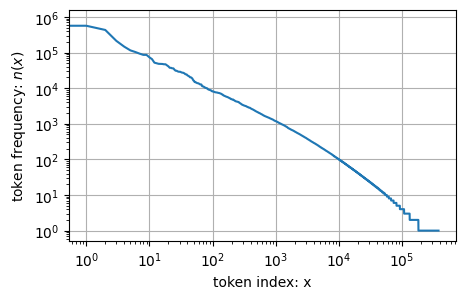

In [50]:
freqs = [freq for token, freq in ch_vocab.token_freqs]
fig = plt.figure(figsize=(5,3))
plt.plot(np.arange(len(freqs)),freqs)
plt.xlabel("token index: x")
plt.ylabel("token frequency: $n(x)$")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)

通过此图我们可以发现：
* **词频以一种明确的方式迅速衰减**，绝大部分单词**大致遵循双对数坐标图上的一条直线**
* 这意味着单词的频率满足**齐普夫定律**，即第 $i$ 个最常用单词的频率 $n_i$ 满足：
    $$
    n_i \propto \frac{1}{i^a}
    $$
    或者等价的：
    $$
    \log{n_i} = -a \log{i} + c
    $$
    其中，$a$ 是刻画分布的参数
* 该分布告诉我们，**想要通过计数统计和Laplace平滑来建模单词概率是不可行的**，因为这样会**大大高估尾部单词的频率**，即**高估不常用单词出现的概率**

对于**二元词组和三元词组，我们依然可以观察到相同的分布**

In [51]:
# 统计二元和三元词组
# corpus = ch_vocab.to_tokens(corpus)
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
# 创建词表
bigram_vocab = Vocab(bigram_tokens)
trigram_vocab = Vocab(trigram_tokens)
# 统计频率
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

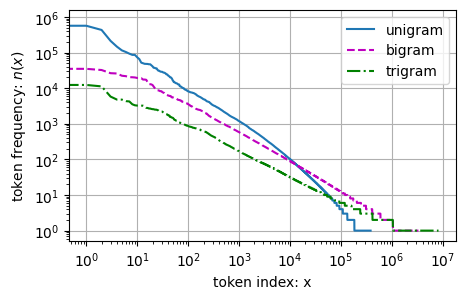

In [52]:
fig = plt.figure(figsize=(5,3))
plt.plot(np.arange(len(freqs)),freqs,'-',label="unigram")
plt.plot(np.arange(len(bigram_freqs)),bigram_freqs,'m--',label="bigram")
plt.plot(np.arange(len(trigram_freqs)),trigram_freqs,'g-.',label="trigram")
plt.xlabel("token index: x")
plt.ylabel("token frequency: $n(x)$")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.legend()

从图上可以观察到的是：
* **除了一元语法词，单词序列也遵循齐普夫定律**
* 词表中**多元组的数量并没有那么大**，这说明语言中存在相当多的结构
* **很多多元组很少出现，这使得拉普拉斯平滑非常不适合语言建模**（高估尾部概率），作为代替，人们使用基于深度学习的模型

最后，我们来讨论模型数据集的生成问题，由于**序列数据本质上是连续的**，而序列中**太久远的信息可能对下一个词的预测帮助不大**，因此我们可以**采用截断拆分序列的方法让模型来读取长序列**

假设我们将使用神经网络来训练语言模型，**模型中的网络一次处理具有预定义时间步的序列**（例如 $T$ 个时间步）的一个小批量（$B$ 个样本，即 $B$ 条序列），现在的问题是如何随机生成一个小批量数据的**特征**和**标签**以供模型使用
* 任意长的序列可以被我们划分为具有相同时间步数的子序列
* 当训练神经网络时，这样的小批量子序列将被输入到模型中

下图绘制了从原始长文本，获取**固定截断长度的子序列**的不同方式：
* 其中，时间步 $T = 5$，模型向后预测 5 步
* **每个时间步的词元对应于一个字符**
* 不同的偏移量会导致不同的子序列
* **因为可以选择任意偏移量来指示初始位置，所以我们有相当大的自由度来生成不同的序列**

<img src="./source/Chap4/时间步.svg" width=500>

在实际使用时，上述的 $5$ 种偏移应该选择哪一个呢？**事实上，他们都一样的好**：
* 如果我们只选择一个固定偏移量，那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的
* 因此，我们可以使用**随机偏移量**划分序列，以同时获得**覆盖性**和**随机性**

我们下面介绍两种常用的**文本子序列采样方法**，实际使用过程中**二者都可，没有太多区别**

**(1) 随机采样策略**

在随机采样中，每个样本都是**在原始的长序列上任意捕获的子序列**
* 在迭代过程中，来自**两个相邻随机的小批量中的子序列不一定在原始序列上相邻**
* 对于语言模型，目标是基于到目前为止我们看到的词元来预测下一个词元，因此**标签是移位了一个词元的原始序列**

In [31]:
# 随机采样策略
def seq_data_iter_random(corpus : list, batch_size, num_steps : int):
    """
    使用随机采样生成一个批量的子序列
    """
    import random

    # 如果 corpus 是拼接后的词元列表，即 corpus 是一个 1D 列表
    # 代表 corpus 中的每个元素是一个词元
    if isinstance(corpus[0],int):
        # 生成随机偏移量 offset
        # 对序列进行分区，随机范围包括 num_steps-1
        offset = random.randint(0, num_steps - 1)
        corpus = corpus[offset:]

        # 子序列的数量
        # 减去 1，因为输出的索引是相应输入的索引加 1
        num_subseqs = (len(corpus) - 1) // num_steps

        # 生成长度为 num_steps 的子序列的起始索引
        initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
        # 随机抽样的策略中，可以打乱索引
        random.shuffle(initial_indices)

        def fetch_data(pos):
            # 返回从 pos 开始的长为 num_steps 的序列
            return corpus[pos:(pos + num_steps)]

        # 批量个数
        num_batches = num_subseqs // batch_size
        for i in range(0, batch_size * num_batches, batch_size):
            # 每个批量的子序列的起始索引
            initial_indices_per_batch = initial_indices[i:(i + batch_size)]
            # 生成一个批量
            X = [fetch_data(pos) for pos in initial_indices_per_batch]
            Y = [fetch_data(pos + 1) for pos in initial_indices_per_batch]
            
            # 返回特征和标签
            yield tf.constant(X), tf.constant(Y)
    
    # 如果 corpus 的每个元素是一个词元列表，即 corpus 是一个 2D 列表
    # 则顺序或随机从 corpus 的每个词元列表采样
    elif isinstance(corpus[0],list):
        random.shuffle(corpus)
        for each_corpus in corpus:
            yield from seq_data_iter_random(each_corpus,batch_size,num_steps)

生成一个 0 到 34 的序列作为 `corpus`，指定时间步 $T = 5$（`num_steps = 5`）
* 这意味着可以生成 $\lfloor (35 - 1)/5 \rfloor = 6$ 个**特征-标签**对
* 当取 `batch_size = 3` 时，我们只能得到 2 个批量
* 可以观察到，**相邻批量中的子序列不是连续的**

In [45]:
my_seq = list(range(35))
for X, Y in ch4.seq_data_iter_random(my_seq, batch_size=3, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[28 29 30 31 32]
 [ 3  4  5  6  7]
 [13 14 15 16 17]], shape=(3, 5), dtype=int32) 
Y: tf.Tensor(
[[29 30 31 32 33]
 [ 4  5  6  7  8]
 [14 15 16 17 18]], shape=(3, 5), dtype=int32)
X:  tf.Tensor(
[[18 19 20 21 22]
 [23 24 25 26 27]
 [ 8  9 10 11 12]], shape=(3, 5), dtype=int32) 
Y: tf.Tensor(
[[19 20 21 22 23]
 [24 25 26 27 28]
 [ 9 10 11 12 13]], shape=(3, 5), dtype=int32)


**(2) 顺序分区采样**

类似上面的采样逻辑，但我们可以**使得两个相邻的小批量中的子序列在原始序列上也是相邻的**
* 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为**顺序分区**

In [14]:
def seq_data_iter_sequential(corpus : list, batch_size : int, num_steps : int):
    """
    使用顺序分区生成一个小批量子序列
    """
    import random

    # 如果 corpus 是拼接后的词元列表，即 corpus 是一个 1D 列表
    # 代表 corpus 中的每个元素是一个词元
    if isinstance(corpus[0],int):
        # 生成随机偏移量 offset
        # 对序列进行分区，随机范围包括 num_steps
        offset = random.randint(0, num_steps)
        # 构成样本的词元数量
        num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size

        # 直接顺序选取文本序列
        Xs = tf.constant(corpus[offset:(offset + num_tokens)])
        Ys = tf.constant(corpus[offset + 1:(offset + 1 + num_tokens)])
        # 变换形状，使得第一维为 batch_size
        Xs = tf.reshape(Xs, (batch_size, -1))
        Ys = tf.reshape(Ys, (batch_size, -1))
        # 批量个数
        num_batches = Xs.shape[1] // num_steps

        for i in range(0, num_steps * num_batches, num_steps):
            # 生成一个批量
            X = Xs[:, i:(i + num_steps)]
            Y = Ys[:, i:(i + num_steps)]

            # 返回特征和标签
            yield X, Y
    
    # 如果 corpus 的每个元素是一个词元列表，即 corpus 是一个 2D 列表
    # 则顺序或随机从 corpus 的每个词元列表采样
    elif isinstance(corpus[0],list):
        random.shuffle(corpus)
        for each_corpus in corpus:
            yield from seq_data_iter_random(each_corpus,batch_size,num_steps)

顺序分区迭代期间**来自两个相邻的小批量中的子序列在原始序列中是相邻的**

In [16]:
my_seq = list(range(35))
for X, Y in ch4.seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[ 3  4  5  6  7]
 [18 19 20 21 22]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[ 4  5  6  7  8]
 [19 20 21 22 23]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[ 8  9 10 11 12]
 [23 24 25 26 27]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[ 9 10 11 12 13]
 [24 25 26 27 28]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[13 14 15 16 17]
 [28 29 30 31 32]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[14 15 16 17 18]
 [29 30 31 32 33]], shape=(2, 5), dtype=int32)


到此为止，我们可以把所有文本预处理的功能封装为类 `SeqDataLoader`

In [ ]:
class SeqDataLoader:
    def __init__(self, file : str, token : str="word", min_freq : int=5, num_steps : int=5, 
                 num_lines : int=10000, concat : bool=False,
                 use_random_iter : bool=True, batch_size : int=32) -> None:
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        # 创建词元，词表，语料库
        self.vocab, self.corpus = chinese_corpus_preprocessing(
            file, num_lines, min_freq, token, concat)
        
        self.batch_size = batch_size
        self.num_steps = num_steps

    # 生成器函数
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)        

### **4.1.4 词嵌入 Embedding**

上一节中，我们处理后的特征和标签的维度是 $X,Y\in \mathbb{R}^{B\times T}$，其中：
* 第一个维度是批量维度，$B$ 表示批量大小
* 第二个维度是时间维度，$T$ 表示时间步长

In [47]:
my_seq = list(range(35))
for X, Y in ch4.seq_data_iter_random(my_seq, batch_size=3, num_steps=5):
    print('X', X, '\nY:', Y)
    break

X tf.Tensor(
[[27 28 29 30 31]
 [12 13 14 15 16]
 [ 2  3  4  5  6]], shape=(3, 5), dtype=int32) 
Y: tf.Tensor(
[[28 29 30 31 32]
 [13 14 15 16 17]
 [ 3  4  5  6  7]], shape=(3, 5), dtype=int32)


In [48]:
(X.shape, Y.shape)

(TensorShape([3, 5]), TensorShape([3, 5]))

批量和时间共同确定一个词元的整数索引，作为模型的输入，但事实上，模型在进行后续计算时，直接使用整数索引也会出现问题：
* 索引的范围跨度很大，10万 个词元就会让索引范围从 0 变换到 $10^5$，如此**巨大的数据变换范围容易导致数值不稳定**
* 模型计算过程中会进行很多的仿射变换，一种直觉是，在**词空间中距离相近的两个词** $x_i,x_j, \|x_i - x_j\|<\epsilon$ **应该具有相似的含义**，因为当我们将 $x_i$ 替换为 $x_j$ 时，**输入只发生了** $\epsilon$ **大小的扰动**，模型的输出结果也应该相似
  * 比如”我喜欢猫“和”我喜欢猫咪“表达的应该是相同的含义
  * 但由于索引是根据词频标号的，因此词表为词元赋予的索引并没有这个性质，甚至**相同含义的词元在索引数轴上可能相差很远**

因此，人们提出了一种**嵌入层**（**Embedding**）的概念，它负责**将每个词元实体映射到一个高维的欧氏空间中**，或者说**将词元的整数索引对应到一个高维的稠密向量**，这时候，每个词元就不再由一个整数 $x_i \in \mathbb{Z}$ 表示，而是由 $\mathbb{R}^e$ 空间中的向量表示，这种技术类型现在普遍称为**Embedding**技术，词嵌入有如下好处：
* 每个词被嵌入后用一个 $\mathbb{R}^e$ 的向量表达，该向量**数值温和**，在模型训练时不易出现数值问题
* 嵌入后的 $\mathbb{R}^e$ 向量表达可以真实表示一个词在词空间中的位置，我们就**可以把相似含义的词映射到** $\mathbb{R}^e$ **中靠近的区域**
* 对词的Ebedding向量进行**聚类分析**，可以**了解词的聚集模式**，分析整个语料的结构

一个自然的问题是，**如何确定将每个词元映射到哪个向量呢**？神经网络模型的做法是，**让这个词嵌入的映射是可学习的**，即将每个词元映射后的向量 $\mathbb{R}^e$ **作为模型参数的一部分**，共同参与**梯度下降更新**

假设语料库中词表的大小是 $v$，我们计划将每个词元索引映射到一个 $\mathbb{R}^e$ 向量，则**需要一个** $E\in\mathbb{R}^{v\times e}$ **的矩阵保存词嵌入后的向量**，这就得到了我们的**Embedding层**

In [53]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size : int, embed_size : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        """
        vocab_size : int
            词表大小
        embed_size : int
            词向量维度
        """
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.vocab_size = vocab_size
        # 初始化 Embedding 层的权重
        self.embedding = self.add_weight(
            name="embedding", shape=(vocab_size, embed_size), trainable=True)
        
    def call(self, inputs, *args, **kwargs):
        """
        inputs : tf.Tensor
            输入的词元序列索引，维度为 (batch_size, num_steps)
        """
        # tf.gather 通过索引获取词元嵌入后的词向量
        return tf.gather(self.embedding, inputs)

在我们刚才 1-35 例子中，词表大小为 35，假设我们将它们嵌入到一个 $\mathbb{R}^8$ 空间中

In [55]:
# 实例化 Embedding 层
layer = ch4.Embedding(vocab_size=35, embed_size=8)

# 计算词嵌入结果
layer(X).shape

TensorShape([3, 5, 8])

可以看到此时嵌入后的特征 $X\in\mathbb{R}^{B\times T\times e}$，前两个特征维度的含义不变，**第三个维度就表示词嵌入空间的维度**

我们单独查看该批量中，**第一个样本，在第二个时间步上词的嵌入结果**

In [58]:
print("第一个样本，在第二个时间步上的词元索引：", X[0, 1].numpy())
# 第一个样本，在第二个时间步上的词嵌入
print("第一个样本，在第二个时间步上的词嵌入：",layer(X)[0, 1, :])

第一个样本，在第二个时间步上的词元索引： 28
第一个样本，在第二个时间步上的词嵌入： tf.Tensor(
[-0.25683346  0.01025683 -0.09339964 -0.00310844 -0.22873394 -0.25677663
 -0.11020333 -0.24167442], shape=(8,), dtype=float32)


这个嵌入后得到的 $\mathbb{R}^8$ 向量，就是 `Embedding` 层中嵌入曾参数 `embedding` 的第 28 行，可以看到结果完全相同

In [59]:
print("嵌入层Embedding的第28行权重：", layer.embedding[28, :])

嵌入层Embedding的第28行权重： tf.Tensor(
[-0.25683346  0.01025683 -0.09339964 -0.00310844 -0.22873394 -0.25677663
 -0.11020333 -0.24167442], shape=(8,), dtype=float32)


最后补充说明，**嵌入层初始化时将词元映射后的高维向量并不能真实表达词元在词空间中的位置**，因为**映射参数是随机初始化的**，只有**经过模型训练之后**，Embedding映射后的词嵌入向量才具有实际意义

此外，**嵌入层的技术和思想已经成为深度学习模型的一种基本想法**，除了词元之外，我们**可以把任何实体都抽象化，嵌入到一个高维的实空间中来表示它**（图像，社交模式，等等），在CNN部分中提到的特征提取器，你也可以理解为，**最后分类全连接层所使用的输入，就是特征提取器处理后，每个实例样本的一个高维空间表示**，它可以当作**Embedding向量**

各种深度学习框架也提供了`Embedding`层的实现，无需我们自己定义

In [60]:
# 使用 Tensorflow 创建 Embedding 层
layer = tf.keras.layers.Embedding(input_dim=35, output_dim=8)

layer(X).shape

TensorShape([3, 5, 8])

----

### **练习**

1. 文件 `./source/data/text/time_traveller.txt` 是一本英文短篇小说，仿照我们中文文本处理的流程，我们以它为例**学习英文文本的预处理工作**
   1. 从路径中读取该文件，文件中总共有多少行文本？
   2. 设计一个用于英语文本的分词函数 `english_tokenize()`，将小说文本进行词元化，你应该设计两种词元化方案，**按单词词元化**，和**按字母词元化**，在实现时，可以注意以下几个方面，以保证得到良好的词元化：
      1. 顺序对文本中的每一行 `line` 进行词元化
      2. 首先考虑应该**去除掉每行** `line` **左右两端的空格，换行符**
      3. 可以考虑通过**正则表达式**，只保留 `line` 中的英文字符和英文标点符号`.,!?`
      4. 在按单词词元化时，中文分词需要 `jieba`，思考**英文文本如何按单词分词**
   3. 创建这本小说的词表 `vocab`
      1. 如果使用**字母词元化**方案，绘制每个字母出现的频率分布图，最常用的字母是谁？
      2. 如果使用**单词词元化**方案，绘制每个单词出现的频率分布图，最常用的三个单词是什么？
   4. 将小说文本处理为语料库数据 `corpus`，由于是小说，**每行文本序列比较短**，因此使用 `concat = True` **将每行语料拼接为一个大语料数据集**
   5. 设计从语料 `corpus` 生成**批量子序列特征和标签**的函数，并将所有功能包装为 `TimeTravellerLoader` 类
      1. 该类需要有 `__iter__` 方法的实现，这样我们可以**通过迭代器依次访问每个批量的数据**
   6. 在实现过程中，测试和保证各个功能的可用性，**最后将它们写入** `./source/code/ch4_hw.py` **文件**，便于后续章节练习使用

2. 词嵌入有一个非常经典的模型叫做**词向量化**：**Word2Vec**（Word to Vector的简称），我们可以通过对该模型的了解，理解**词嵌入的意义**和 `Embedding` 层工作的思想和原理
   1. 搜索相关资料，了解 `Word2Vec` 模型的基本思想，**为了获得每个词元在嵌入词空间的正确表示，Word2Vec 构建了什么任务去驱动参数的学习**？
   2. 想要使用 `word2Vec` 非常简单，有很多 Python 库实现了 `Word2Vec` 模型，例如：
      ```python
      !pip install gensim
      from gensim.models import Word2Vec
      ```
   3. 词嵌入一般会根据语料库大小选择词嵌入后词向量空间的维度，例如 `embed_size = 64`
        1. 一般这是一个高维空间，我们无法对其直接进行观测，但可以**利用降维技术**把词向量空间可视化到 **2 维**，**3 维**
        2. 最常用的两种降维技术是 **主成分分析 PCA** 和 **t分布随机邻居嵌入 t-SNE**
        3. 可以去 `Tensorflow` 提供的词嵌入可视化网页 [Embedding Projector](https://projector.tensorflow.org/)，直观操作和查看降维后的词嵌入空间
           1. 你可以在右侧页面搜索一个词，**观察词嵌入空间中它的最近邻**
              1. 例如搜索 `apple`，和它最近邻的 5 个词是什么？你觉得模型的词义理解正确吗？
              2. 可以在左下角调整降维方法，尝试 `PCA` 和 `t-SNE`，观察降维效果

----